In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import os
from timeit import default_timer as timer
from typing import Tuple, List, Type, Dict, Any

##  Load and examine the data

In [2]:
with open('./geo_kaggle_data/index.pkl', 'rb') as f:
    data_index = pickle.load(f)
data_index[1:3]

[{'jpg_filename': 'img-2019-12-11T09-56-17devID2.jpg',
  'lon': -10.775719833333333,
  'lat': 41.35916666666667,
  'mask_fname': 'AMK79/masks/mask-id2.png',
  'mission': 'AMK79',
  'devID': 2,
  'observations_dt': datetime.datetime(2019, 12, 11, 10, 0),
  'observed_TCC': 4},
 {'jpg_filename': 'img-2019-12-11T10-04-17devID1.jpg',
  'lon': -10.7849575,
  'lat': 41.33913483333333,
  'mask_fname': 'AMK79/masks/mask-id1.png',
  'mission': 'AMK79',
  'devID': 1,
  'observations_dt': datetime.datetime(2019, 12, 11, 10, 0),
  'observed_TCC': 4}]

In [3]:
dataframe = pd.DataFrame(data_index)

In [4]:
dataframe.head()

,jpg_filename,lon,lat,mask_fname,mission,devID,observations_dt,observed_TCC
0,img-2019-12-11T10-02-37devID2.jpg,-10.783049,41.343315,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 10:00:00.000,4
1,img-2019-12-11T09-56-17devID2.jpg,-10.775720,41.359167,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 10:00:00.000,4
2,img-2019-12-11T10-04-17devID1.jpg,-10.784958,41.339135,AMK79/masks/mask-id1.png,AMK79,1,2019-12-11 10:00:00.000,4
3,img-2019-12-11T14-00-00devID2.jpg,-11.037792,40.761531,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 13:59:59.975,1
4,img-2019-12-11T12-58-20devID2.jpg,-10.973738,40.909492,AMK79/masks/mask-id2.png,AMK79,2,2019-12-11 12:59:59.980,1


In [5]:
dataframe['observed_TCC'].describe()

count    92077.000000
mean         5.008927
std          2.998372
min          0.000000
25%          2.000000
50%          6.000000
75%          8.000000
max          8.000000
Name: observed_TCC, dtype: float64

<AxesSubplot:xlabel='observed_TCC', ylabel='Count'>

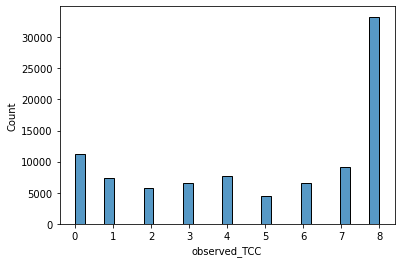

In [6]:
sns.histplot(dataframe['observed_TCC'])

We can see that the data is skewed. It might be useful to apply augmentation to all labels except 8.  

In [7]:
dataframe.groupby(by = 'mission').mean()['observed_TCC']

mission
ABP42    4.243454
AI49     8.000000
AI52     5.586468
AMK79    5.553050
ANS31    5.181746
Name: observed_TCC, dtype: float64

Check labels of mission ```AI49```, because all of them has label *8*, which is kinda sus.

In [8]:
index = (dataframe['mission'] == 'AI49')

In [9]:
dataframe.loc[index, 'observed_TCC'].describe()

count    160.0
mean       8.0
std        0.0
min        8.0
25%        8.0
50%        8.0
75%        8.0
max        8.0
Name: observed_TCC, dtype: float64

So the whole data of ```AI49``` is annotated with *8*  
But on photos it seems to have label 0, 1 or 2, so the whole data of ```AI49``` is misslabeled. It has only 160 samples, hence we can drop it without dealing any serious damage to the model.

I'll use only columns ```jpg_filename```, ```mission```, ```observations_dt```, ```observed_TCC```, beacause others are no use for the model.

In [10]:
dataframe = dataframe[['jpg_filename', 'mission', 'observations_dt', 'observed_TCC']]

In [11]:
dataframe = dataframe.set_index('mission').drop(labels = 'AI49')

In [12]:
dataframe = dataframe.reset_index(drop = False)

In [13]:
dataframe

,mission,jpg_filename,observations_dt,observed_TCC
0,AMK79,img-2019-12-11T10-02-37devID2.jpg,2019-12-11 10:00:00.000,4
1,AMK79,img-2019-12-11T09-56-17devID2.jpg,2019-12-11 10:00:00.000,4
2,AMK79,img-2019-12-11T10-04-17devID1.jpg,2019-12-11 10:00:00.000,4
3,AMK79,img-2019-12-11T14-00-00devID2.jpg,2019-12-11 13:59:59.975,1
4,AMK79,img-2019-12-11T12-58-20devID2.jpg,2019-12-11 12:59:59.980,1
...,...,...,...,...
91912,ANS31,img-2016-01-03T13-56-08devID1.jpg,2016-01-03 14:00:00.000,7
91913,ANS31,img-2016-01-03T07-01-23devID1.jpg,2016-01-03 07:00:02.000,5
91914,ANS31,img-2016-01-03T14-58-53devID1.jpg,2016-01-03 15:00:04.000,1
91915,ANS31,img-2016-01-03T07-00-53devID2.jpg,2016-01-03 07:00:02.000,5


## Create custom dataset

In [14]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, annotations, root_dir, transforms = None):
        
        super().__init__()
        
        self.annotations = annotations
        self.root_dir = os.path.abspath(root_dir)
        self.transforms = transforms
        
    def __len__(self):
        
        return len(self.annotations)
        
    def __getitem__(self, index):
        
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index]['mission'], 'snapshots', 'snapshots-'+str((self.annotations.iloc[index]['observations_dt']).date()), self.annotations.iloc[index]['jpg_filename'])
        image = plt.imread(img_path)
        label = torch.tensor(int(self.annotations.iloc[index]['observed_TCC']))
        
        if self.transforms:
            image = self.transforms(image)
        
        return (image, label)

In [15]:
transforms = tf.Compose([tf.ToPILImage(), tf.RandomHorizontalFlip(), tf.RandomVerticalFlip(), tf.RandomRotation(20), tf.ToTensor()])

In [16]:
SkyData = CustomDataset(dataframe, root_dir = 'geo_kaggle_data', transforms = transforms)

In [17]:
SkyData[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor(4))

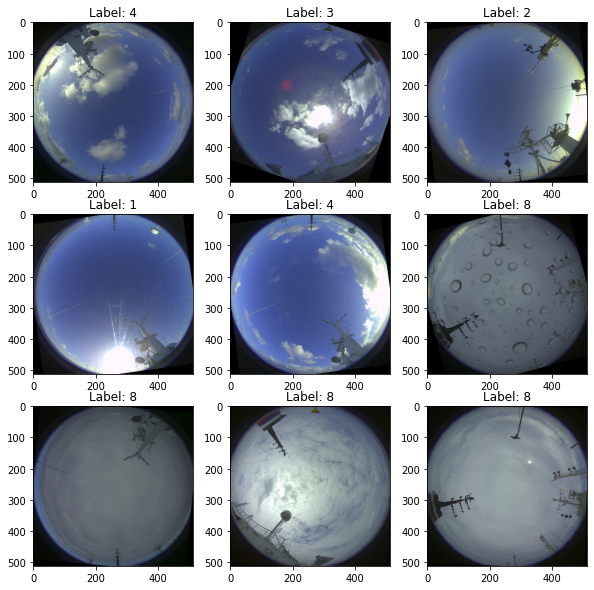

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample, label = SkyData[i*325+j*13122]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0))
        ax.set_title('Label: {}'.format(int(label)))

In [19]:
class Net(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (512, 512),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.Tanh,
                 num_classes: int = 9):
        
        super().__init__()
        
        self.input_resolution = input_resolution
        self.input_channels = input_channels
        self.hidden_layer_features = hidden_layer_features
        self.activation = activation()
        self.num_classes = num_classes
        
        self.conv1 = torch.nn.Conv2d(3, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 32 , 3, 1)
        
        self.dropout1 = torch.nn.Dropout(0.25)
        
        self.fc1 = torch.nn.Linear(28*28*32, 128)
        self.fc2 = torch.nn.Linear(128, 9)
        
    def forward(self, X):
        
        X = self.conv1(X)
        X = F.relu(X)
        X = self.conv2(X)
        X = F.relu(X)
        
        X = self.dropout(X)
        X = X.view(-1, 28*28*32)
        
        X = self.fc1(X)
        X = F.tanh(X)
        X = self.fc2(X)
        output = F.log_softmax(X, dim = 1)
        
        return output

In [20]:
def train_single_epoch(model : torch.nn.Module,
                       optimizer : torch.optim.Optimizer,
                       loss_function : torch.nn.Module,
                       data_loader : torch.utils.data.DataLoader):
    
    model.train()
    loss_total = 0
    
    for data in data_loader:
        
        X, y = data
        X, y = X.to(device), y.to(device)
        
        model.zero_grad()
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        loss.backward()
        
        optimizer.step()
    
    loss_avg = loss_total / len(data_loader.dataset)
    
    return loss_avg

In [21]:
@torch.no_grad()
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    loss_total = 0
    accuracy_total = 0
    
    for data in data_loader:
        
        X, y = data
        X, y = X.to(device), y.to(device)
        
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        
        y_pred = output.argmax(dim = 1, keepdim = True).to(device)
        accuracy_total += y_pred.eq(y.view_as(y_pred)).sum().item()
        
    loss_avg = loss_total / len(data_loader.dataset)
    accuracy_avg = 100.0 * accuracy_total / len(data_loader.dataset)
    
    return {'loss' : loss_avg, 'accuracy' : accuracy_avg}

In [22]:
def plot_learning_curves(loss_list, accuracy_list, best_epoch):
    """
    Plot loss evolution on training and dev sets and
    accuracy evolution on dev set
    """
    
    # Plot learning loss curve
    plt.plot(loss_list['train'], label = 'Training set')
    plt.plot(loss_list['valid'], label = 'Dev set')
    plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best model')
    plt.title('Loss evolution')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Plot accuracy curve         
    plt.plot(accuracy_list, color = 'g', label = 'Dev set')
    plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best model')
    plt.title('Accuracy evolution on validation set')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [23]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                valid_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 20, 
                best_model_root = './best_model.pth'):
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    best_valid_loss = None
    best_epoch = None
    loss_list = {'train' : list(), 'valid' : list()}
    accuracy_list = list()
    
    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
        
        start = timer()
        
        train_loss = train_single_epoch(model, optimizer, loss_function, train_loader)
        
        # Evaluate perfomance on the training set
        loss_list['train'].append(train_loss)
        
        # Evaluate perfomance on the cross-validation set
        valid_metrics = validate_single_epoch(model, loss_function, valid_loader)
        loss_list['valid'].append(valid_metrics['loss'])
        accuracy_list.append(valid_metrics['accuracy'])
        
        print('time:', timer() - start)
        print(f'Validation metrics: \n{valid_metrics}')

        lr_scheduler.step(valid_metrics['loss'])
        
        if best_valid_loss is None or best_valid_loss > valid_metrics['loss']:
            print(f'-----Best model yet, saving-----')
            best_valid_loss = valid_metrics['loss']
            best_epoch = epoch
            torch.save(model, best_model_root)
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            plot_learning_curves(loss_list, accuracy_list, best_epoch)
            return

## Create a model

In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU', f'({torch.cuda.get_device_name()})')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU (GeForce MX250)


In [25]:
model = Net()
model.to(device)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Net(
  (activation): Tanh()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=25088, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)
Total number of trainable parameters 3222697


In [29]:
train_dataset, valid_dataset = torch.utils.data.random_split(SkyData, [len(SkyData) - 15000, 15000])

### Train

In [32]:
train_model(model, 
            train_dataset=train_dataset, 
            valid_dataset=valid_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01, max_epochs = 500, batch_size = 512)

Epoch 0


RuntimeError: CUDA out of memory. Tried to allocate 1.50 GiB (GPU 0; 2.00 GiB total capacity; 12.29 MiB already allocated; 1.34 GiB free; 16.00 MiB reserved in total by PyTorch)